In [35]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [284]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [350]:
row = cat.iloc[66]
test_filename = row.filename
arrival_time_rel = row['time_rel(sec)']
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
print(test_filename, arrival_time_rel, arrival_time)

xa.s12.00.mhz.1974-06-25HR00_evid00149 1380.0 1974-06-25 00:23:00


In [351]:
data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1974-06-25T00:00:00.524000Z - 1974-06-26T00:00:03.844755Z | 6.6 Hz, 572423 samples

In [352]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1974-06-25T00:00:00.524000Z
         endtime: 1974-06-26T00:00:03.844755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [353]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

1379.476

Text(0.5, 1.0, 'xa.s12.00.mhz.1974-06-25HR00_evid00149')

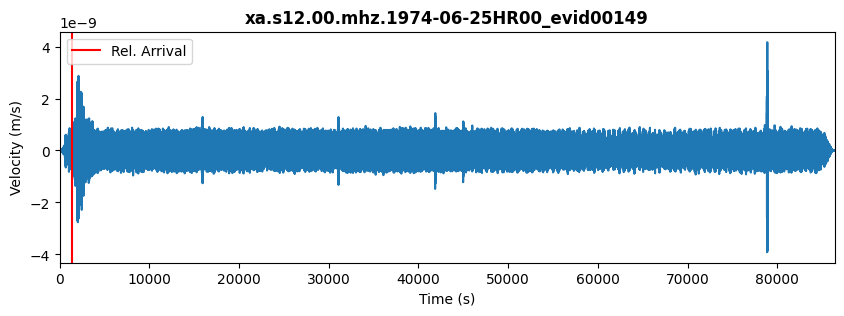

In [354]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

In [355]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.5

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [356]:
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

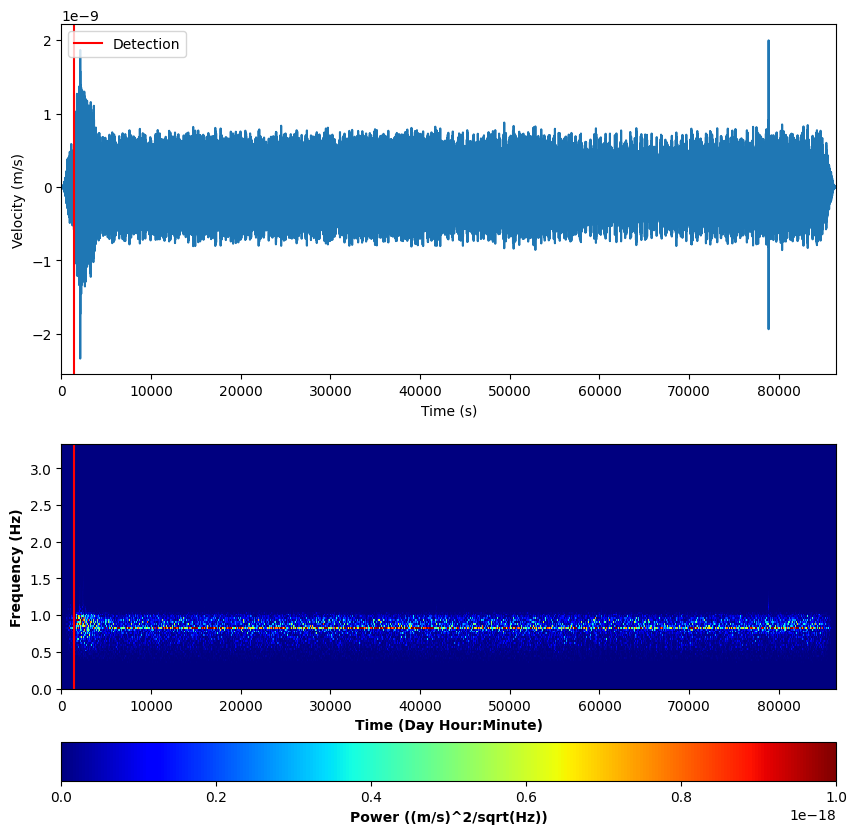

In [357]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=1e-18)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

In [358]:
tr_filt.stats.sampling_rate

6.625

Text(0, 0.5, 'Characteristic function')

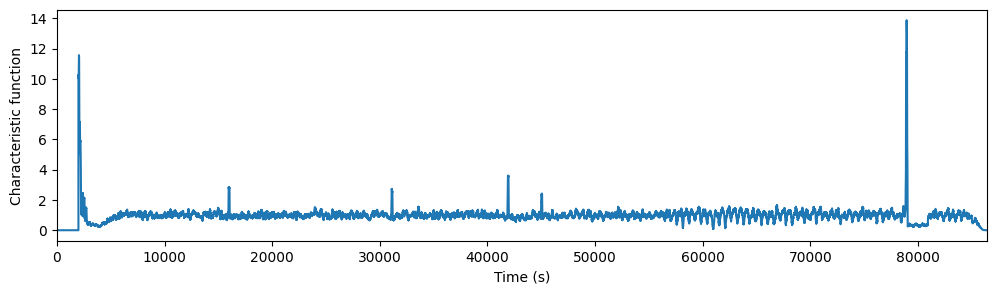

In [359]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 100
lta_len = 2000

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


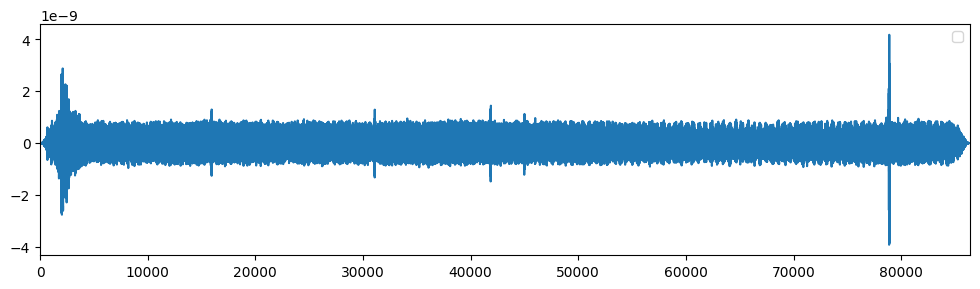

In [360]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 5
thr_off = 1
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    if abs(triggers[0]-triggers[1]) >3000:
    
        ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
        ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

Text(0, 0.5, 'Characteristic function')

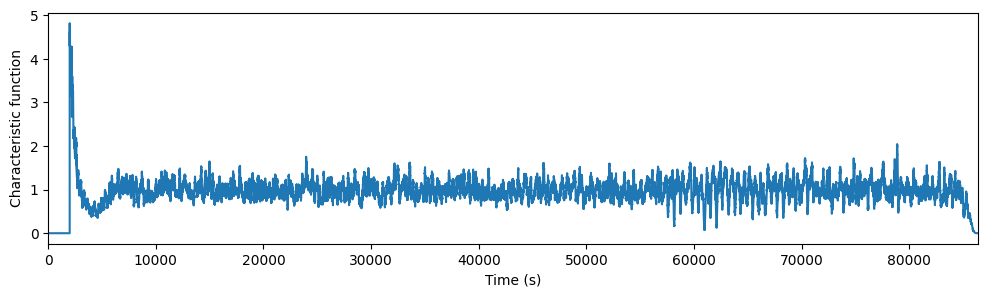

In [361]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr_filt.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 100
lta_len = 2000

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data_filt, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times_filt,cft)
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


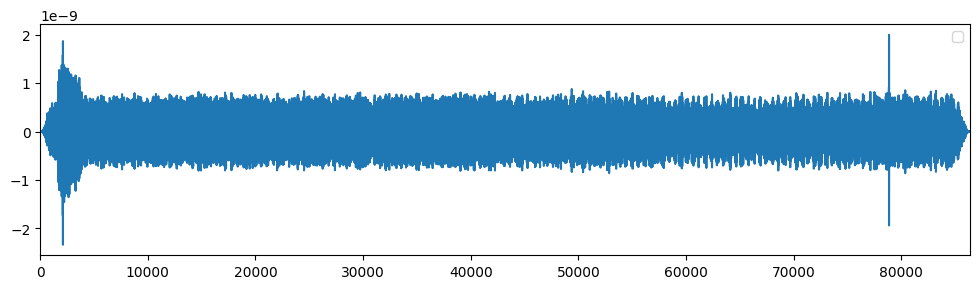

In [362]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 5
thr_off = 1.
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

#print(on_off[i])
# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    if abs(triggers[0]-triggers[1]) >3200:
        ax.axvline(x = tr_times_filt[triggers[0]], color='red', label='Trig. On')
        ax.axvline(x = tr_times_filt[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times_filt,tr_data_filt)
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.legend()

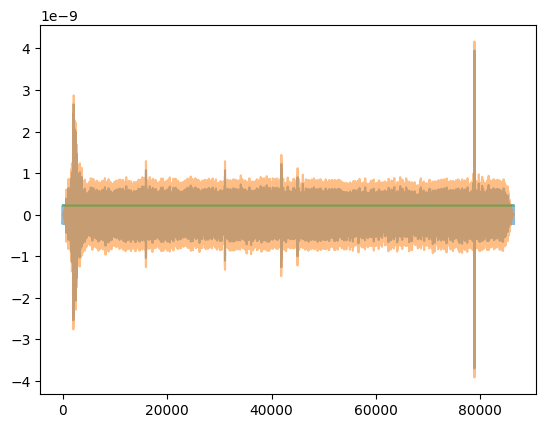

In [363]:
tr_data1 = tr_data - np.sign(tr_data)*np.mean(np.abs(tr_data))
plt.plot(tr_times,tr_data1,alpha=0.5)
plt.plot(tr_times,tr_data,alpha=0.5)
plt.plot(tr_times,np.mean(np.abs(tr_data))*tr_data**0,alpha=.5)
plt.show()

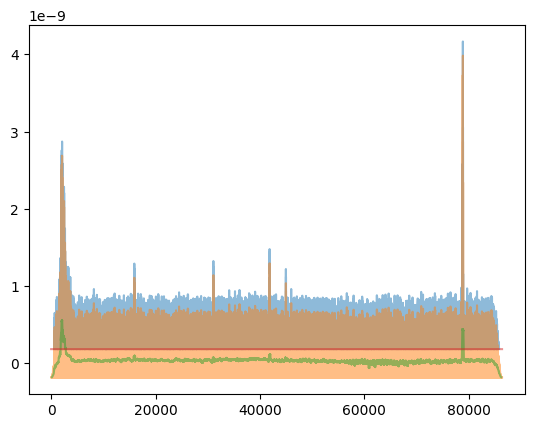

In [365]:
tr_data2 = np.abs(tr_data[np.abs(tr_data)>np.median(np.abs(tr_data))])
tr_times2 = tr_times[np.abs(tr_data)>np.median(np.abs(tr_data))]
tr_data3 = np.abs(tr_data) - np.median(np.abs(tr_data))
window_size = 2001
 
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
 
# Loop through the array to consider
# every window of size 3
moving_averages = np.convolve(tr_data3, np.ones(window_size) / window_size, mode='valid')

time_lost = window_size//2
tr_times4 = tr_times[time_lost:-1*time_lost]
tr_data4 = moving_averages
plt.plot(tr_times2,tr_data2,alpha=0.5)
plt.plot(tr_times,tr_data3,alpha=0.5)
plt.plot(tr_times4,tr_data4,alpha=0.5)
plt.plot(tr_times,np.median(np.abs(tr_data))*tr_data**0,alpha=.5)
plt.show()

In [366]:
def testing(tr_times_filt,tr_data_filt,tr_filt_sampling_rate):
    # Sampling frequency of our trace
    df = tr_filt_sampling_rate
    
    # How long should the short-term and long-term window be, in seconds?
    sta_len = 100
    lta_len = 2700
    
    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    cft = classic_sta_lta(tr_data_filt, int(sta_len * df), int(lta_len * df))
    
    # Plot characteristic function
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(tr_times_filt,cft)
    ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')
    plt.show()

    # Play around with the on and off triggers, based on values in the characteristic function
    thr_on = 2.75
    thr_off = 1.
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    # The first column contains the indices where the trigger is turned "on". 
    # The second column contains the indices where the trigger is turned "off".
    
    #print(on_off[i])
    # Plot on and off triggers
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    #for i in np.arange(0,len(on_off)):
        #triggers = on_off[i]
        #if abs(triggers[0]-triggers[1]) > 3000:
            #print(tr_times_filt[triggers[0]])

    results = []
    areas = []
    for i in np.arange(0,len(on_off)):
        triggers = on_off[i]
        if abs(triggers[0]-triggers[1]) > 3000:
            results.append([triggers[0],triggers[1]])      
            areas.append([tr_times_filt[triggers[0]],simps(tr_data_filt[triggers[0]:triggers[1]+1],tr_times_filt[triggers[0]:triggers[1]+1])])
    
    if len(areas) == 0:
        return 
    areas = np.asarray(areas)
    results = np.asarray(results)
    max_area = np.max(areas[:,1])

    mask10 = areas[:,1] >= 2.5*10**-7
    survive_area = areas[mask10]
    results = results[mask10]
    for area, triggers in zip(survive_area,results):
        print(area)
        ax.axvline(x = tr_times_filt[triggers[0]], color='red', label='Trig. On')
        ax.axvline(x = tr_times_filt[triggers[1]], color='purple', label='Trig. Off')
    
    # Plot seismogram
    ax.plot(tr_times_filt,tr_data_filt)
    ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax.legend()
    plt.show()
    return

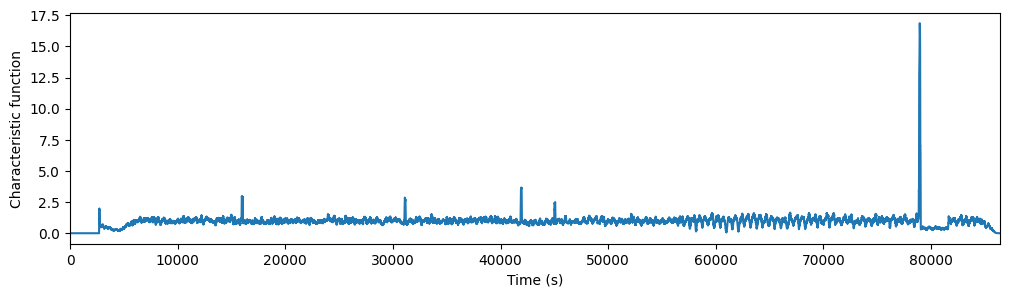

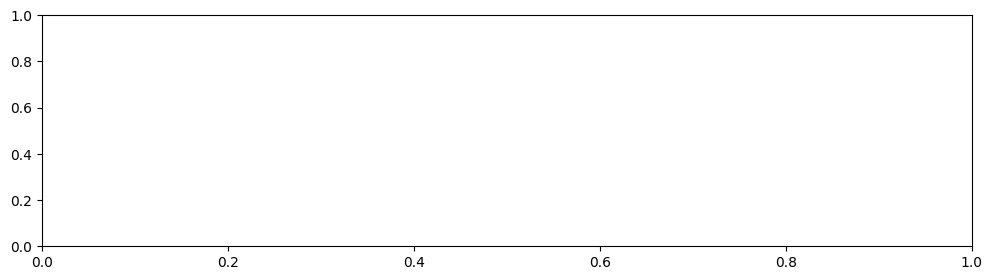

In [367]:
testing(tr_times,tr_data,tr.stats.sampling_rate)

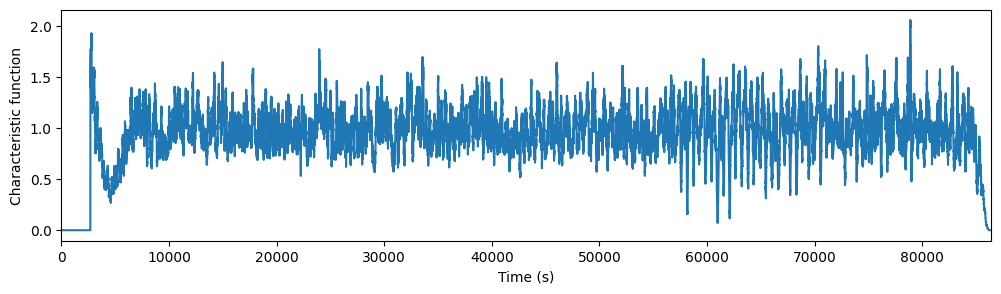

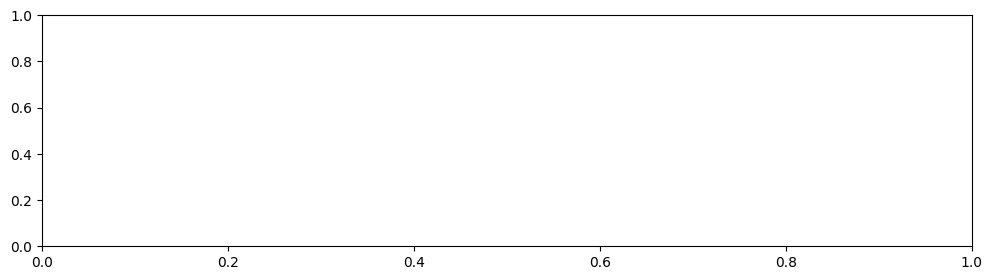

In [368]:
testing(tr_times_filt,tr_data_filt,tr_filt.stats.sampling_rate)

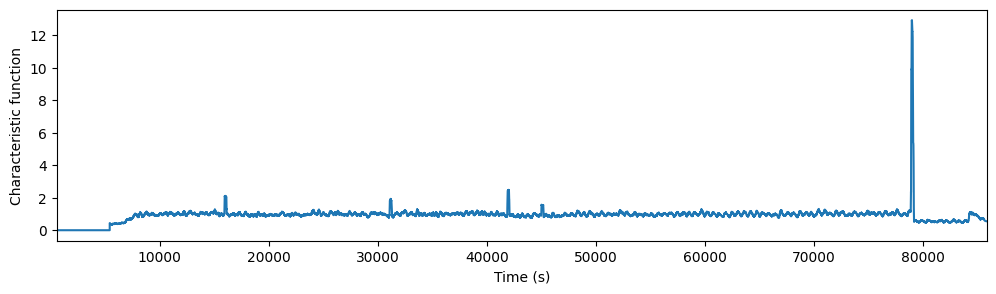

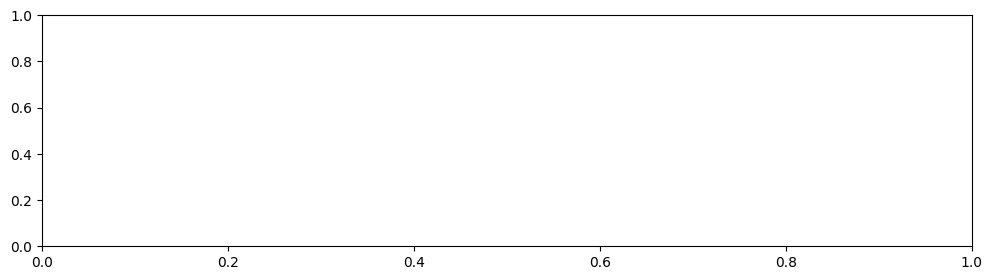

In [369]:
testing(tr_times2,tr_data2,tr.stats.sampling_rate)

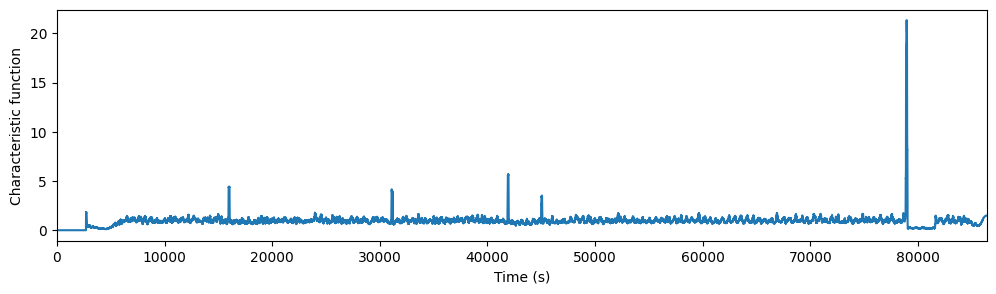

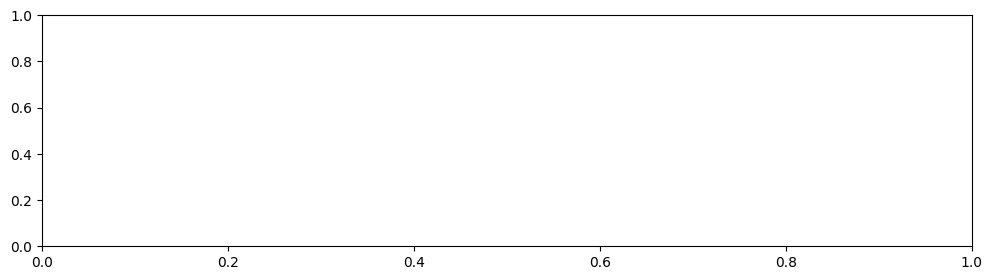

In [370]:
testing(tr_times,np.abs(tr_data) - np.median(np.abs(tr_data)),tr.stats.sampling_rate)

In [371]:
print(tr_times4.shape,tr_data4.shape)

(570423,) (570423,)


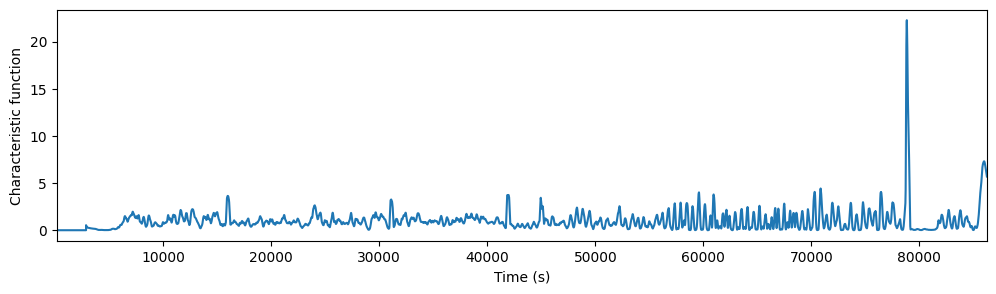

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


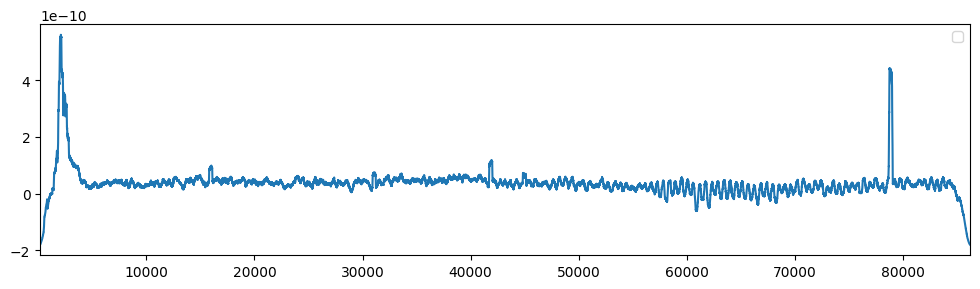

In [372]:
testing(tr_times4,tr_data4,tr.stats.sampling_rate)

## Algoritmo para comparar

In [177]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
import numpy as np
from scipy.integrate import simps

In [282]:
def primer_algo(mseed_file1):
    st = read(mseed_file1)

    ## This is how you get the data and the time, which is in seconds
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    ## Bandpass
    # Set the minimum frequency
    minfreq = 0.5
    maxfreq = 1.5

    # Going to create a separate trace for the filter data
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data
    
    mask = np.abs(tr_data_filt)>np.median(np.abs(tr_data_filt))
    #tr_times_filt = tr_times_filt[mask]
    #tr_data_filt = np.abs(tr_data_filt[mask])
    tr_data_filt = np.abs(tr_data_filt) - np.median(np.abs(tr_data_filt))
    ## Create LTA algoritm
    # Sampling frequency of our trace
    df = tr.stats.sampling_rate

    window_size = 1001
 
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []
     
    # Loop through the array to consider
    # every window of size 3
    #moving_averages = np.convolve(tr_data_filt, np.ones(window_size) / window_size, mode='valid')

    #time_lost = window_size//2
    #tr_times_filt = tr_times_filt[time_lost:-1*time_lost]
    #tr_data_filt = moving_averages
    
    # How long should the short-term and long-term window be, in seconds?
    sta_len = 100
    lta_len = 2700
    
    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    cft = classic_sta_lta(tr_data_filt, int(sta_len * df), int(lta_len * df))
    
    ## Haciendo el corte
    # Play around with the on and off triggers, based on values in the characteristic function
    thr_on = 2.75 #2.75
    thr_off = 1.5 #1.
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    # The first column contains the indices where the trigger is turned "on". 
    # The second column contains the indices where the trigger is turned "off".

    results = []
    areas = []
    for i in np.arange(0,len(on_off)):
        triggers = on_off[i]
        if abs(triggers[0]-triggers[1]) > 3000:
            results.append(tr_times_filt[triggers[0]])      
            areas.append([tr_times_filt[triggers[0]],simps(tr_data_filt[triggers[0]:triggers[1]+1],tr_times_filt[triggers[0]:triggers[1]+1])])
    
    if len(areas) == 0:
        return []
    areas = np.asarray(areas)
    max_area = np.max(areas[:,1])

    survive_area = areas[areas[:,1] >= 2.5*10**-7]
    
    return list(survive_area[:,0])

In [275]:
primer_algo(mseed_file)

[2706.4150943396226]

In [276]:
3//2

1

In [277]:
x = 100.
y=1500

In [280]:
import numpy as np
def comparar(func):

    cat_directory = './data/lunar/training/catalogs/'
    cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
    cat = pd.read_csv(cat_file)

    # Extracting all names and true values
    filenames = cat['filename'].values
    #print(filenames[0])
    true_values = cat['time_rel(sec)'].values

    data_directory = './data/lunar/training/data/S12_GradeA/'
    values = []
    casos_vacio = []
    double_plus = []
    i=0
    for filename, true_result in list(zip(filenames,true_values))[:-1]:
        #print(filename,true_result)
        mseed_file = f'{data_directory}{filename}.mseed'
        algo_result = func(mseed_file)
        if algo_result == []:
            casos_vacio.append(i)
        else:
            values.append([algo_result,true_result])
            if len(algo_result) >1:
                double_plus.append([i,len(algo_result)])
        i+=1

    print('No se encontraron eventos en',len(casos_vacio),'casos')
    if len(casos_vacio) > 0:
        print('En los siguientes archivos:', casos_vacio)
    if len(double_plus) > 0:
        print(f'Hay mas de uno en {len(double_plus)} casos: {double_plus}')
        
    y_pred = np.asarray([min(p, key=lambda x: abs(x - t)) for p,t in values])
    y_true = np.asarray([i[-1] for i in values])
    print(np.min(np.abs(((y_true - y_pred) / y_true)*100)),np.max(np.abs(((y_true - y_pred) / y_true)*100)))
    return np.mean(np.abs((y_true - y_pred) / ((y_true+y_pred)/2))) * 100
    #return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [283]:
comparar(primer_algo) 

No se encontraron eventos en 1 casos
En los siguientes archivos: [66]
Hay mas de uno en 13 casos: [[7, 2], [8, 2], [22, 2], [23, 2], [25, 2], [36, 2], [37, 2], [40, 2], [48, 2], [49, 2], [54, 2], [67, 2], [68, 2]]
0.008786533481317266 20.842036924325416


1.0443077202859674

In [224]:
comparar(primer_algo) #5.5

No se encontraron eventos en 4 casos
En los siguientes archivos: [14, 65, 66, 74]
Hay mas de uno en 30 casos: [[0, 2], [3, 2], [7, 3], [8, 3], [20, 2], [21, 2], [22, 2], [23, 2], [25, 2], [26, 2], [27, 2], [34, 2], [36, 2], [37, 2], [40, 2], [42, 2], [43, 4], [44, 2], [47, 2], [48, 3], [49, 3], [52, 4], [53, 3], [55, 2], [56, 4], [61, 4], [63, 2], [67, 2], [68, 2], [71, 5]]


1.341864247522626

In [217]:
comparar(primer_algo) #5

No se encontraron eventos en 3 casos
En los siguientes archivos: [14, 66, 74]
Hay mas de uno en 32 casos: [[0, 2], [3, 2], [5, 2], [7, 3], [8, 3], [11, 2], [20, 2], [21, 2], [22, 2], [23, 2], [25, 2], [26, 2], [27, 2], [34, 2], [36, 2], [37, 2], [40, 2], [42, 5], [43, 4], [44, 2], [47, 2], [48, 3], [49, 3], [52, 4], [53, 3], [55, 2], [56, 4], [61, 4], [63, 2], [67, 2], [68, 2], [71, 5]]


1.2996412665399721

In [230]:
comparar(primer_algo) #3

No se encontraron eventos en 2 casos
En los siguientes archivos: [14, 66]
Hay mas de uno en 48 casos: [[0, 7], [3, 2], [4, 2], [5, 6], [7, 3], [8, 3], [9, 2], [11, 4], [13, 2], [15, 4], [16, 2], [18, 2], [20, 2], [21, 2], [22, 2], [23, 2], [24, 2], [25, 2], [26, 2], [27, 3], [30, 3], [32, 2], [33, 2], [34, 2], [36, 2], [37, 2], [38, 2], [40, 2], [41, 2], [42, 7], [43, 6], [44, 2], [47, 2], [48, 3], [49, 3], [52, 7], [53, 4], [54, 5], [55, 2], [56, 4], [57, 2], [61, 5], [63, 2], [67, 4], [68, 4], [70, 2], [71, 6], [72, 2]]


1.1877933622534902

In [228]:
comparar(primer_algo) #4

No se encontraron eventos en 2 casos
En los siguientes archivos: [14, 66]
Hay mas de uno en 38 casos: [[0, 5], [3, 2], [5, 3], [7, 3], [8, 3], [9, 2], [11, 2], [13, 2], [15, 2], [20, 2], [21, 2], [22, 2], [23, 2], [25, 2], [26, 2], [27, 2], [33, 2], [34, 2], [36, 2], [37, 2], [40, 2], [42, 5], [43, 4], [44, 2], [47, 2], [48, 3], [49, 3], [52, 5], [53, 4], [54, 3], [55, 2], [56, 4], [61, 4], [63, 2], [67, 2], [68, 2], [71, 5], [72, 2]]


1.2867532107159452

In [221]:
comparar(primer_algo) #5

No se encontraron eventos en 4 casos
En los siguientes archivos: [14, 65, 66, 74]
Hay mas de uno en 30 casos: [[0, 2], [3, 2], [7, 3], [8, 3], [20, 2], [21, 2], [22, 2], [23, 2], [25, 2], [26, 2], [27, 2], [34, 2], [36, 2], [37, 2], [40, 2], [42, 2], [43, 4], [44, 2], [47, 2], [48, 3], [49, 3], [52, 4], [53, 3], [55, 2], [56, 4], [61, 4], [63, 2], [67, 2], [68, 2], [71, 5]]


1.341864247522626

In [232]:
comparar(primer_algo) #2.75

No se encontraron eventos en 2 casos
En los siguientes archivos: [14, 66]
Hay mas de uno en 49 casos: [[0, 8], [3, 2], [4, 2], [5, 6], [7, 3], [8, 3], [9, 3], [11, 4], [13, 2], [15, 4], [16, 2], [18, 2], [20, 3], [21, 2], [22, 2], [23, 2], [24, 2], [25, 2], [26, 2], [27, 3], [30, 3], [32, 2], [33, 2], [34, 2], [36, 2], [37, 2], [38, 2], [40, 2], [41, 2], [42, 7], [43, 6], [44, 3], [45, 2], [47, 2], [48, 3], [49, 3], [52, 8], [53, 4], [54, 5], [55, 2], [56, 4], [57, 2], [61, 5], [63, 3], [67, 4], [68, 4], [70, 2], [71, 6], [72, 4]]


1.149874369436787